# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Litecoin cryptocurrency and the minimum threshold is 0.5

In [ ]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
start = "1514761200" # 01.01.2018
periods = 88 # approx 8 years
TICKER = "LTCUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS, diff1 = high + low, extreme = high - low
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR="LTCUSDT:high"
TIME = "LTCUSDT:time"

In [ ]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,LTCUSDT:time,LTCUSDT:high,LTCUSDT:low,LTCUSDT:close,LTCUSDT:volume
0,2018-01-01 00:00:00,0.000000,-2.878984,-1.658545,-15.483775
1,2018-01-01 01:00:00,0.570125,-2.969213,-2.964652,19.188441
2,2018-01-01 02:00:00,1.992949,0.000000,1.678026,-36.832104
3,2018-01-01 03:00:00,2.447731,-0.236429,1.117241,36.486647
4,2018-01-01 04:00:00,2.911242,0.000000,2.672841,-13.130611
...,...,...,...,...,...
63255,2025-03-24 18:00:00,0.434184,-0.465954,0.254157,24.030034
63256,2025-03-24 19:00:00,0.348579,-0.211260,-0.116193,-15.324418
63257,2025-03-24 20:00:00,0.898805,-0.010574,0.422967,30.305838
63258,2025-03-24 21:00:00,0.652769,-0.452727,-0.052643,11.568597


In [4]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data["LTCUSDT:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data["LTCUSDT:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

MAX HIGH IN DATASET: 37.93103448275862
OCCURRENCES OVER 0.5: 28642 - PERCENT OF DATASET: 0.4527663610496364
OCCURRENCES OVER 0.6: 24421
OCCURRENCES OVER 0.7: 20767
OCCURRENCES OVER 0.8: 17789
OCCURRENCES OVER 0.9: 15320
OCCURRENCES OVER 1: 13265 - PERCENT OF DATASET: 0.20969016756244072
----------------------------------------------------------------------
MAX CLOSE IN DATASET: 24.942528735632187
OCCURRENCES OVER 0.5: 13774 - PERCENT OF DATASET: 0.2177363262725261
OCCURRENCES OVER 0.6: 11600
OCCURRENCES OVER 0.7: 9803
OCCURRENCES OVER 0.8: 8363
OCCURRENCES OVER 0.9: 7216
OCCURRENCES OVER 1: 6236 - PERCENT OF DATASET: 0.09857730003161555


In [5]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:volume0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:volume1,LTCUSDT:high2,...,LTCUSDT:volume2,LTCUSDT:high3,LTCUSDT:low3,LTCUSDT:close3,LTCUSDT:volume3,LTCUSDT:high4,LTCUSDT:low4,LTCUSDT:close4,LTCUSDT:volume4,Label
0,2018-01-01 04:00:00,0.000000,-2.878984,-1.658545,-15.483775,0.570125,-2.969213,-2.964652,19.188441,1.992949,...,-36.832104,2.447731,-0.236429,1.117241,36.486647,2.911242,0.000000,2.672841,-13.130611,1
1,2018-01-01 05:00:00,0.570125,-2.969213,-2.964652,19.188441,1.992949,0.000000,1.678026,-36.832104,2.447731,...,36.486647,2.911242,0.000000,2.672841,-13.130611,0.723343,-0.549205,0.107162,-31.348340,1
2,2018-01-01 06:00:00,1.992949,0.000000,1.678026,-36.832104,2.447731,-0.236429,1.117241,36.486647,2.911242,...,-13.130611,0.723343,-0.549205,0.107162,-31.348340,2.952984,-0.388081,2.551521,58.440409,0
3,2018-01-01 07:00:00,2.447731,-0.236429,1.117241,36.486647,2.911242,0.000000,2.672841,-13.130611,0.723343,...,-31.348340,2.952984,-0.388081,2.551521,58.440409,0.039146,-2.222609,-2.096473,-29.899582,1
4,2018-01-01 08:00:00,2.911242,0.000000,2.672841,-13.130611,0.723343,-0.549205,0.107162,-31.348340,2.952984,...,58.440409,0.039146,-2.222609,-2.096473,-29.899582,0.830631,-0.946120,-0.279838,51.699673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63250,2025-03-24 17:00:00,0.289700,-0.590129,0.257511,116.883451,1.648116,-0.042808,0.171233,57.410332,0.673005,...,-64.905523,0.318708,-0.849888,-0.350579,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0
63251,2025-03-24 18:00:00,1.648116,-0.042808,0.171233,57.410332,0.673005,-0.384574,0.555496,-64.905523,0.318708,...,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0.434184,-0.465954,0.254157,24.030034,0
63252,2025-03-24 19:00:00,0.673005,-0.384574,0.555496,-64.905523,0.318708,-0.849888,-0.350579,-2.092758,0.970046,...,-7.516904,0.434184,-0.465954,0.254157,24.030034,0.348579,-0.211260,-0.116193,-15.324418,1
63253,2025-03-24 20:00:00,0.318708,-0.849888,-0.350579,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0.434184,...,24.030034,0.348579,-0.211260,-0.116193,-15.324418,0.898805,-0.010574,0.422967,30.305838,1


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [6]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = ["LTCUSDT:high0", "LTCUSDT:low0", "LTCUSDT:close0", "LTCUSDT:volume0", "LTCUSDT:high1", "LTCUSDT:low1", "LTCUSDT:close1", "LTCUSDT:volume1", "LTCUSDT:high2", "LTCUSDT:low2", "LTCUSDT:close2", "LTCUSDT:volume2", "LTCUSDT:high3", "LTCUSDT:low3", "LTCUSDT:close3", "LTCUSDT:volume3", "LTCUSDT:high4", "LTCUSDT:low4", "LTCUSDT:close4", "LTCUSDT:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250329_141309"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.61 GB / 15.92 GB (41.5%)
Disk Space Avail:   139.93 GB / 475.69 GB (29.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [7]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


{'accuracy': 0.6939,
 'balanced_accuracy': 0.6628141415717264,
 'mcc': 0.34301477703425637,
 'roc_auc': 0.7379231391365483,
 'f1': 0.5703859649122807,
 'precision': 0.6448746429704856,
 'recall': 0.5113236034222446,
 'confusion_matrix':       0     1
 0  4907  1119
 1  1942  2032,
 'classification_report': {'0': {'precision': 0.7164549569280186,
   'recall': 0.8143046797212081,
   'f1-score': 0.7622524271844661,
   'support': 6026.0},
  '1': {'precision': 0.6448746429704856,
   'recall': 0.5113236034222446,
   'f1-score': 0.5703859649122807,
   'support': 3974.0},
  'accuracy': 0.6939,
  'macro avg': {'precision': 0.6806647999492521,
   'recall': 0.6628141415717264,
   'f1-score': 0.6663191960483734,
   'support': 10000.0},
  'weighted avg': {'precision': 0.688008940161295,
   'recall': 0.6939,
   'f1-score': 0.6860046950774996,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	41.97s	= Expected runtime (8.39s per shuffle set)
	34.18s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
LTCUSDT:high4,0.03304,0.005362,0.000080,5,0.044080,0.022000
LTCUSDT:close4,0.02456,0.005540,0.000291,5,0.035966,0.013154
LTCUSDT:high3,0.01264,0.001682,0.000037,5,0.016103,0.009177
LTCUSDT:high0,0.00440,0.001581,0.001698,5,0.007656,0.001144
LTCUSDT:low4,0.00380,0.002102,0.007791,5,0.008129,-0.000529
LTCUSDT:low0,0.00364,0.004237,0.063546,5,0.012363,-0.005083
LTCUSDT:high1,0.00248,0.002918,0.065064,5,0.008487,-0.003527
LTCUSDT:high2,0.00248,0.003233,0.080719,5,0.009137,-0.004177
LTCUSDT:close2,0.00236,0.001664,0.016899,5,0.005786,-0.001066
LTCUSDT:low1,0.00148,0.001911,0.079180,5,0.005415,-0.002455


In [8]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.790789,0.209211
1,0.805934,0.194066
2,0.802027,0.197973
3,0.783368,0.216632
4,0.835715,0.164285
...,...,...
9995,0.564299,0.435701
9996,0.557582,0.442418
9997,0.611921,0.388079
9998,0.641320,0.358680


,Label
0,0
1,0
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,0
9998,0


,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:volume0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:volume1,LTCUSDT:high2,LTCUSDT:low2,...,LTCUSDT:volume2,LTCUSDT:high3,LTCUSDT:low3,LTCUSDT:close3,LTCUSDT:volume3,LTCUSDT:high4,LTCUSDT:low4,LTCUSDT:close4,LTCUSDT:volume4,Label
0,0.235919,-0.265408,0.147449,14.759800,0.103062,-0.250294,-0.117786,-24.123583,0.280112,-0.206398,...,40.116752,0.162410,-0.147645,0.059058,-53.877174,0.265604,-0.132802,0.147558,21.634221,0
1,0.103062,-0.250294,-0.117786,-24.123583,0.280112,-0.206398,-0.162170,40.116752,0.162410,-0.147645,...,-53.877174,0.265604,-0.132802,0.147558,21.634221,0.147362,-0.162098,0.088417,53.266541,0
2,0.280112,-0.206398,-0.162170,40.116752,0.162410,-0.147645,0.059058,-53.877174,0.265604,-0.132802,...,21.634221,0.147362,-0.162098,0.088417,53.266541,0.014723,-0.412250,-0.206125,-7.793346,0
3,0.162410,-0.147645,0.059058,-53.877174,0.265604,-0.132802,0.147558,21.634221,0.147362,-0.162098,...,53.266541,0.014723,-0.412250,-0.206125,-7.793346,0.368840,-0.044261,0.206551,42.557459,0
4,0.265604,-0.132802,0.147558,21.634221,0.147362,-0.162098,0.088417,53.266541,0.014723,-0.412250,...,-7.793346,0.368840,-0.044261,0.206551,42.557459,0.132489,-0.117768,0.073605,-28.824782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.289700,-0.590129,0.257511,116.883451,1.648116,-0.042808,0.171233,57.410332,0.673005,-0.384574,...,-64.905523,0.318708,-0.849888,-0.350579,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0
9996,1.648116,-0.042808,0.171233,57.410332,0.673005,-0.384574,0.555496,-64.905523,0.318708,-0.849888,...,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0.434184,-0.465954,0.254157,24.030034,0
9997,0.673005,-0.384574,0.555496,-64.905523,0.318708,-0.849888,-0.350579,-2.092758,0.970046,-0.202537,...,-7.516904,0.434184,-0.465954,0.254157,24.030034,0.348579,-0.211260,-0.116193,-15.324418,1
9998,0.318708,-0.849888,-0.350579,-2.092758,0.970046,-0.202537,0.650251,-7.516904,0.434184,-0.465954,...,24.030034,0.348579,-0.211260,-0.116193,-15.324418,0.898805,-0.010574,0.422967,30.305838,1


MEAN PROB 1 CLASSIFICATION: 0.4271352469012141
MAX PROB 1 CLASSIFICATION: 0.945351243019104
MIN PROB 1 CLASSIFICATION: 0.11043152213096619
COUNT OF NUMBERS > 0.7: 626
COUNT OF NUMBERS > 0.8: 130
COUNT OF NUMBERS > 0.9: 8


In [ ]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset["LTCUSDT:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset["LTCUSDT:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
# Analysis of returns made by trading strategy

MINIMUM_PROBABILITY = 0.8
LEVERAGE = 5
GAIN = 0.5

CORRECT = 0
NUM_TRADES = 0
BAD_TRADES = []
ALL_TRADES = []
invested = 100
invested_list = []

for index, probbb in enumerate(validation_probabilities[1].to_list()):

    # IF THE PREDICTION HAS A SUFFICIENT PROBABILITY
    if probbb >= MINIMUM_PROBABILITY:
        NUM_TRADES += 1

        # IF THE PREDICTION IS CORRECT
        if validation_predictions["Label"][index] == validation_dataset["Label"][index]:
            CORRECT += 1
            ALL_TRADES.append(GAIN * LEVERAGE)
            invested *= 1 + (GAIN / 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

        # IF THE PREDICTION IS INCORRECT    
        else:
            true_close = validation_dataset["LTCUSDT:close4"][index + 1]
            bad_trad = (round(true_close * LEVERAGE, 3), round(probbb, 3))
            BAD_TRADES.append(bad_trad)
            ALL_TRADES.append(true_close * LEVERAGE)
            invested *= 1 + (true_close/ 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

    else:
        copyy = invested
        invested_list.append(copyy)



print(f"CORRECT: {CORRECT}")
print(f"WRONG: {NUM_TRADES - CORRECT}")
print(f"NUMBER OF TRADES: {NUM_TRADES}")
print(f"WINRATE: {round(CORRECT / NUM_TRADES, 3) * 100}%")
print(f"RETURN: {round(invested - 100, 3)} %")
print(f"IVESTMENT VALUE: {invested}")
print("----------------------------------")
for btbb in BAD_TRADES:
    print(btbb)


from matplotlib import pyplot as plt

plt.plot(invested_list)
plt.show()




In [ ]:
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.8
LEVERAGE = 5

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2["LTCUSDT:high4"][index + 1]
        true_low = test_data_frame2["LTCUSDT:low4"][index + 1]
        true_close = test_data_frame2["LTCUSDT:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")

CORRECT: 70
WRONG: 60
NUMBER OF TRADES: 130
WIN RATE: 53.85%
----------------------------------
MEAN GOOD TRADES: 1.7975293957217577
MEAN BAD TRADES: -1.1652698867265647
INVESTMENT VALUE 169.44939840021394


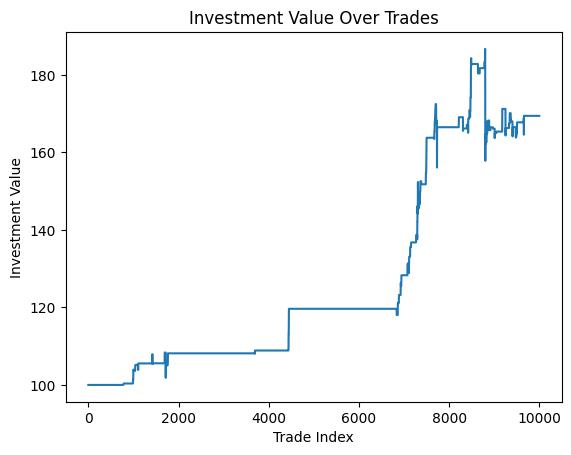

In [13]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0.25:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()